In [44]:
import tensorflow as tf
import jax
import flax
from flax import linen as nn
from jax import numpy as jnp
from jax import random
from einops import einsum, rearrange, reduce
import optax
import matplotlib.pyplot as plt
import pickle
import time
import numpy as np
from flax.training import orbax_utils

import orbax.checkpoint

import functools


import os
import uuid
import datetime

from maze_dataset.plotting import MazePlot
from maze_dataset.tokenization.token_utils import strings_to_coords

from dataset import CustomMazeDataset
from dataset import NumpyLoader

from model import TransformerLM, TransformerConfig


In [45]:

# config details
checkpoint_path = "data/2023-10-31_16-24-46"
base_path = "data"
save = True

np_seed = 0
jnp_seed = 0

batch_size = 128
lr = 1e-4
n_train_steps = 10000000

save_every_n_steps = 1000
keep_n_checkpoints = 100

n_worker = 8

# n_eval = 1024
emb_dim: int = 256
num_heads: int = 16
num_layers: int = 12
qkv_dim: int = 256  # 512
mlp_dim: int = 1024  # 2048
max_len = 256

grid_n = 5

In [46]:



@jax.jit
def train_step(state, batch):
    params = state['params']
    opt_state = state['opt_state']
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)
    updates, opt_state = tx.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    step = state['step'] + 1

    return {'params': params, 'opt_state': opt_state, 'loss': loss, 'step': step}

@jax.jit
def eval_step(state, batch):
    params = state['params']
    loss = loss_fn(params, batch)
    return loss

dataset = CustomMazeDataset(include_maze=False, no_loops=False)
train_loader = NumpyLoader(dataset, batch_size=batch_size, num_workers=0)

losses = []
eval_losses = []

key = random.PRNGKey(jnp_seed)
rng, key = random.split(key)

config = TransformerConfig(
    vocab_size=dataset.vocab_size,
    output_vocab_size=dataset.vocab_size,
    max_len=max_len,
    emb_dim=emb_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    qkv_dim=qkv_dim,
    mlp_dim=mlp_dim
)

model = TransformerLM(config=config)


def loss_fn(params, batch):
    preds, act = model.apply(params, batch['data'])
    preds = preds[:, 0:-1]
    targets = batch['data'][:, 1:]
    idx = jnp.arange(targets.shape[1])[None, :]
    mask = jnp.where((idx < batch['end_index'][:, None]) & (idx >= batch['start_index'][:, None]), 1., 0.)

    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=preds,
        labels=targets
    ) * mask

    loss = loss.sum() / mask.sum()

    return loss

tx = optax.adamw(lr)

batch = next(iter(train_loader))
params = model.init(rng, batch['data'])

apply_fn = jax.jit(model.apply)

opt_state = tx.init(params)

state = {'params': params, 'opt_state': opt_state, 'loss': 0., 'step': 0}

# checkpoint management / loading model

if save and not checkpoint_path:
    # make new run dir ect

    # Get the current date and time
    current_datetime = datetime.datetime.now()

    # Create a directory name with the date and unique ID
    checkpoint_dir_name = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # Create the full path for the checkpoint directory
    checkpoint_path = os.path.join(base_path, checkpoint_dir_name)

    # Check if the directory already exists
    if not os.path.exists(checkpoint_path):
        # Create the directory
        os.makedirs(checkpoint_path)
        print(f"Checkpoint directory created: {checkpoint_path}")
    else:
        print(f"Checkpoint directory already exists: {checkpoint_path}")

if checkpoint_path:
    orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=keep_n_checkpoints)
    checkpoint_manager = orbax.checkpoint.CheckpointManager(checkpoint_path, orbax_checkpointer, options)

    dummy_dict = {
        'state': state,
        'loss': np.array([0.])}


    step = checkpoint_manager.latest_step()

    if step:
        print(f'loading step {step}')
        load_dict = checkpoint_manager.restore(step, items=dummy_dict)
        state = load_dict['state']
        losses = list(load_dict['loss'])



loading step 953000


In [47]:
vocab_size = dataset.vocab_size

In [48]:
reverse_map = {v: k for k, v in dataset.tokenizer.tokenizer_map.items()}
vocab_map = dataset.tokenizer.tokenizer_map.get


from dataset import find_from_right

def ints_to_coords(arr):
    # Map the integers in the list back to their corresponding tokens
    tok_list = [reverse_map.get(i) for i in list(np.array(arr))]
    coords = strings_to_coords(tok_list[:find_from_right(tok_list,'<PATH_END>')])
    return coords

In [49]:
target_dict = {
      11: 0,
      27: 1,
      29: 2,
      35: 3
}

[(key,reverse_map[key]) for key in target_dict.keys()]

[(11, '(0,0)'), (27, '(0,4)'), (29, '(4,0)'), (35, '(4,4)')]

In [50]:
model.apply(state["params"], batch["data"][:2], intervention=lambda x, layer: x)

(Array([[[-2.2925186 , -9.66244   , -9.907211  , ..., -0.9442662 ,
          -1.1290259 , -2.6165648 ],
         [-0.8948841 , -9.754123  , -9.954762  , ...,  0.14824662,
           1.0293977 , -2.3105125 ],
         [-0.3035698 , -8.340952  , -8.459057  , ..., -1.580883  ,
           1.0039791 , -0.9462584 ],
         ...,
         [-5.9620266 , -6.274772  , -6.017227  , ...,  3.5738044 ,
           5.1489944 , -1.874038  ],
         [-5.986547  , -6.319866  , -6.06932   , ...,  3.5182464 ,
           5.3181996 , -2.0328465 ],
         [-5.990076  , -6.3157988 , -6.078826  , ...,  3.476007  ,
           5.5620255 , -2.3814485 ]],
 
        [[-2.2925186 , -9.66244   , -9.907211  , ..., -0.9442662 ,
          -1.1290259 , -2.6165648 ],
         [ 4.034581  , -8.958638  , -9.150868  , ...,  0.91503996,
           1.8288373 , -1.6985562 ],
         [-0.8893857 , -8.4069    , -8.503858  , ..., -1.7510009 ,
           0.91976726, -0.8688119 ],
         ...,
         [-5.862006  , -6.136293 

# Probe training

In [8]:
class LinearProbe(nn.Module):

  @nn.compact
  def __call__(self, x):
    # input should be batch_size x n_layers (one probe per layer) x emb_dim
    #y = nn.Dense(features=128)(x)
    #y = nn.relu(y)
    #y = nn.Dense(features=64)(x)
    #y = nn.relu(y)
    # treat the layers as 1 D spatial dimension, the model dim as channel dim
    bs = x.shape[0]
    #print(x.shape)
    W = self.param('W', nn.initializers.xavier_uniform(), (num_layers+1, emb_dim, 4))
    b = self.param('b', nn.initializers.zeros, (num_layers, 4))
    assert x.shape == (bs, num_layers+1, emb_dim)
    x = nn.LayerNorm(reduction_axes=2, feature_axes=(1,2))(x)
    y = einsum(W, x, 'l m o, bs l m -> bs l o')
    return y

#def concat_acts(act, first_layer, last_layer):
#  assert len(act['stream'])>=last_layer
#  stream = act['stream'][first_layer:last_layer+1]
#  #concat along model dim (i.e. keep batch and sequence positions separate)
# acts = jnp.concatenate(stream,axis=-1)
#  #print(acts.shape)
#  #acts = acts[:,:,:]
#  #print(acts.shape)
#  return acts

def prepare_acts(act):
    assert act['stream'][0].shape[0] == batch_size, act['stream'][0].shape[2] == emb_dim
    seq_len = act['stream'][0].shape[1]
    # note: input has dimensions n_layer x batch_size x sequence_len x emb_dim
    
    acts  = rearrange(act['stream'], 'layer bs seq dim -> (bs seq) layer dim')

    
    # return a tensor in which all seq positions are in one big batch, then layer, then model dim
    assert len(acts.shape)==3
    assert acts.shape == (batch_size * seq_len, num_layers+1, emb_dim)

    return acts, seq_len

[(11, '(0,0)'), (27, '(0,4)'), (29, '(4,0)'), (35, '(4,4)')]

In [55]:
# Linear probe training

# Start a new experiment


losses = []
eval_losses = []

#batch = next(iter(train_loader))


key = random.PRNGKey(0)

rng, key = random.split(key)


#print(f'default loss: {jnp.log()}')

pred, act = model.apply(state['params'], batch['data'])

acts, seq_len = prepare_acts(act) # this is just to initialize the probe, so take first sequence position arbitrarily

x = acts

probe = LinearProbe()

tx = optax.adamw(1e-4)

params = probe.init(rng, x)

opt_state = tx.init(params)

probe_state = {'params': params, 'opt_state': opt_state, 'loss': 0., 'step': 0}

@functools.partial(jax.jit, static_argnums=(2,))
def probe_loss_fn(params, batch, reduce_layers = 1):
  pred, act = model.apply(state['params'], batch['data'])
      
  acts, seq_len = prepare_acts(act)
  assert seq_len == batch['data'].shape[1]

  targets = batch['data'][jnp.arange(0,pred.shape[0]),batch['end_index']-1]

  #print(targets)

  new_targets = targets.copy()

  for k, v in target_dict.items():
      new_targets = jnp.where(targets==k,v,new_targets)

  #print(new_targets)
  # expanding targets along seq len (result is shape 
  repeated_targets = jnp.repeat(new_targets, seq_len, axis = 0)
  assert repeated_targets.shape == (seq_len * batch_size,)
  repeated_targets = jnp.repeat(repeated_targets[:,None], num_layers+1, axis=1)
  assert repeated_targets.shape == (seq_len * batch_size,num_layers+1)
  

  probe_pred = probe.apply(params, acts)

  # probe preds are of shape (batch_size * seq_len, num_layer, 4)

  assert repeated_targets.shape == probe_pred.shape[:-1]

  assert len(repeated_targets.shape)==2

  loss = optax.softmax_cross_entropy_with_integer_labels(
      logits = probe_pred,
      labels = repeated_targets
  )

  # loss is of shape (batch_size * seq_len, num_layer). First, undo the reshaping.

  loss = rearrange(loss, '(bs seq) layer -> bs seq layer', bs=batch_size, seq=seq_len, layer=num_layers+1)
  
  idx = jnp.arange(seq_len)[None, :]

  mask = jnp.where((idx < batch['end_index'][:, None]) & (idx > batch['start_index'][:, None]), 1., 0.)

  # need to broadcast mask over the last layer dimension
  assert mask.shape == (batch_size,seq_len)
  loss = loss * mask[:,:,None]

  if reduce_layers:
      # just add up losses over all the layers. that's fine.
      loss = loss.sum() / mask.sum()
  else:
      loss = loss.sum(axis=(0,1))/mask.sum()

  return loss

@jax.jit
def probe_train_step(probe_state,batch):
  params = probe_state['params']
  opt_state = probe_state['opt_state']
  loss, grads = jax.value_and_grad(probe_loss_fn)(params,batch)
  updates, opt_state = tx.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  step = probe_state['step'] + 1

  return {'params': params, 'opt_state': opt_state, 'loss': loss, 'step': step}

@jax.jit
def probe_eval_step(state,batch):
  params = state['params']
  loss = probe_loss_fn(params,batch)
  return loss

probe_losses = []
probe_eval_losses = []


In [56]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
probe_options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=keep_n_checkpoints)
probe_checkpoint_manager = orbax.checkpoint.CheckpointManager(os.path.join(base_path,'probe_layernorm'), orbax_checkpointer, probe_options)

In [11]:
# PROBE LOADING
dummy_dict = {
            'probe_state': probe_state,
            'probe_loss': np.zeros(1)}

step = probe_checkpoint_manager.latest_step()
print(f'loading step {step}')
load_dict = probe_checkpoint_manager.restore(step, items=dummy_dict)
probe_state = load_dict['probe_state']
probe_losses = list(load_dict['probe_loss'])
print(np.mean(probe_losses[-100:]))

loading step 20686
12.87562


(13, 256)

In [65]:
dataset = CustomMazeDataset(include_maze=False)
train_loader = NumpyLoader(dataset, batch_size=batch_size, num_workers=n_worker)

loop_time = time.time()

for n, batch in enumerate(train_loader):
    # do the actual training


    probe_state = probe_train_step(probe_state, batch)
    
    probe_losses.append(probe_state['loss'])
    
    print(f'step: {probe_state["step"]}')
    print('loss: {}'.format(probe_state['loss']))
    old_time = loop_time
    loop_time = time.time()
    print('steps per second: {:.5f}'.format(1/(loop_time - old_time)))

    if n % 100 == 0:

        probe_save_step = probe_state['step']
        print(f'saving at step {probe_save_step}')
        probe_save_dict = {'probe_state': probe_state,
                     'probe_loss': np.array(probe_losses)
                     }
        probe_save_args = orbax_utils.save_args_from_target(probe_save_dict)
        probe_checkpoint_manager.save(probe_save_step, probe_save_dict, save_kwargs={'save_args': probe_save_args})
    

# note that completely oblivious loss is 1.3862944 for 4 options (since dataset is uniformly random)

step: 5510
loss: 12.657626152038574
steps per second: 0.17714
saving at step 5510
step: 5511
loss: 12.968436241149902
steps per second: 0.50686
step: 5512
loss: 13.28481388092041
steps per second: 0.52609
step: 5513
loss: 13.763984680175781
steps per second: 0.49709
step: 5514
loss: 13.004992485046387
steps per second: 0.51999
step: 5515
loss: 12.81805419921875
steps per second: 0.51158
step: 5516
loss: 13.165980339050293
steps per second: 0.49981
step: 5517
loss: 13.04987907409668
steps per second: 0.47349
step: 5518
loss: 13.651626586914062
steps per second: 0.51088
step: 5519
loss: 13.520942687988281
steps per second: 0.47637
step: 5520
loss: 12.93362045288086
steps per second: 0.49341
step: 5521
loss: 13.125049591064453
steps per second: 0.46736
step: 5522
loss: 12.849335670471191
steps per second: 0.51577
step: 5523
loss: 12.95433235168457
steps per second: 0.50834
step: 5524
loss: 13.536529541015625
steps per second: 0.51088
step: 5525
loss: 13.381667137145996
steps per second: 0

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x29cabf130>
Traceback (most recent call last):
  File "/Users/johannes/miniforge3/envs/maze-goal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/johannes/miniforge3/envs/maze-goal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/johannes/miniforge3/envs/maze-goal/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/johannes/miniforge3/envs/maze-goal/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/johannes/miniforge3/envs/maze-goal/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/Users/johannes/miniforge3/envs/maze-goal/lib/python3.

KeyboardInterrupt: 

13.095689
18.021826694558577
1.3862943611198906
using act after layer: 0
loss: 1.2108434438705444
using act after layer: 1
loss: 1.0893806219100952
using act after layer: 2
loss: 1.082209587097168
using act after layer: 3
loss: 1.0648179054260254
using act after layer: 4
loss: 1.046172022819519
using act after layer: 5
loss: 1.0359259843826294
using act after layer: 6
loss: 1.0106688737869263
using act after layer: 7
loss: 0.9685900807380676
using act after layer: 8
loss: 0.937695324420929
using act after layer: 9
loss: 0.8680493235588074
using act after layer: 10
loss: 0.8241008520126343
using act after layer: 11
loss: 0.8331452012062073
using act after layer: 12
loss: 0.9320255517959595


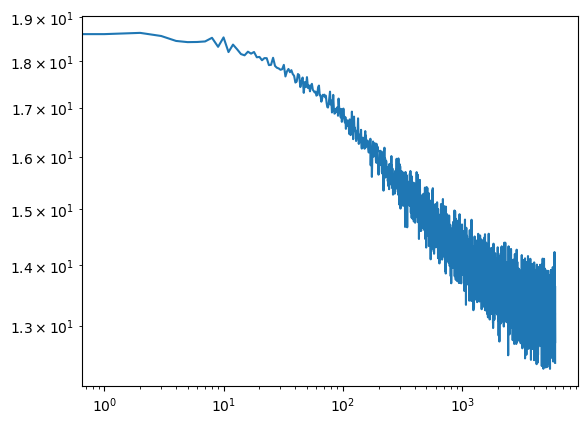

In [68]:
plt.plot(probe_losses)
plt.yscale('log')
plt.xscale('log')

print(np.mean(probe_losses[-100:]))
print(-13*np.log(1/4))
print(-np.log(1/4))

loss = probe_loss_fn(probe_state['params'], batch, reduce_layers = False)

for layer in range(13):
    print(f'using act after layer: {layer}')
    print(f'loss: {loss[layer]}')

In [66]:
# PROBE SAVING
probe_save_step = probe_state['step']
print(f'saving at step {probe_save_step}')
probe_save_dict = {'probe_state': probe_state,
             'probe_loss': np.array(probe_losses)
             }
probe_save_args = orbax_utils.save_args_from_target(probe_save_dict)
probe_checkpoint_manager.save(probe_save_step, probe_save_dict, save_kwargs={'save_args': probe_save_args})

saving at step 6009


True

# Baseline probe training

In [38]:
embeddings = jnp.array(state['params']['params']['decoder']['Embed_0']['embedding'])

def get_baseline_features(data):
    # Baseline features:
    # for simplicity, we just concatenate the embeddings of the past two tokens.
    data = jnp.array(data)
    features = embeddings[data]

    two_step_features = jnp.concatenate([features[:,:-1,:],features[:,1:,:]],axis=-1)
    seq_len = two_step_features.shape[1]
    out = rearrange(two_step_features, 'bs seq feat -> (bs seq) feat')

    return out, seq_len
    

n_baseline_probe_layers = 1
n_hidden = emb_dim

class BaselineProbe(nn.Module):
    @nn.compact
    def __call__(self, x):
        for layer in range(n_baseline_probe_layers):
            x = nn.Dense(n_hidden)(x)
            x = nn.relu(x)
        out = nn.Dense(4)(x)
        return out

In [39]:
# Linear probe training

# Start a new experiment

losses = []
eval_losses = []

#batch = next(iter(train_loader))


key = random.PRNGKey(0)

rng, key = random.split(key)

baseline_probe = BaselineProbe()

x, seq_len = get_baseline_features(batch['data'])

tx = optax.adamw(1e-4)

params = baseline_probe.init(rng, x)

opt_state = tx.init(params)

baseline_state = {'params': params, 'opt_state': opt_state, 'loss': 0., 'step': 0}

@jax.jit
def baseline_loss_fn(params, batch):
  inputs, seq_len = get_baseline_features(batch['data'])
      
  assert seq_len == batch['data'].shape[1] - 1

  targets = batch['data'][jnp.arange(0,batch_size),batch['end_index']-1]

  new_targets = targets.copy()

  for k, v in target_dict.items():
      new_targets = jnp.where(targets==k,v,new_targets)

  #print(new_targets)
  # expanding targets along seq len (result is shape 
  repeated_targets = jnp.repeat(new_targets, seq_len, axis = 0)
  assert repeated_targets.shape == (seq_len * batch_size,)

  probe_pred = baseline_probe.apply(params, inputs)

  assert repeated_targets.shape == probe_pred.shape[:-1]

  assert len(repeated_targets.shape)==1

  loss = optax.softmax_cross_entropy_with_integer_labels(
      logits = probe_pred,
      labels = repeated_targets
  )

  # loss is of shape (batch_size * seq_len, num_layer). First, undo the reshaping.

  loss = rearrange(loss, '(bs seq) -> bs seq', bs=batch_size, seq=seq_len)
  
  idx = jnp.arange(seq_len)[None, :]

  mask = jnp.where((idx < batch['end_index'][:, None]-1) & (idx > batch['start_index'][:, None]-1), 1., 0.)

  # need to broadcast mask over the last layer dimension
  assert mask.shape == (batch_size,seq_len)
  loss = loss * mask
  loss = loss.sum()/mask.sum()

  return loss

@jax.jit
def baseline_train_step(baseline_state,batch):
  params = baseline_state['params']
  opt_state = baseline_state['opt_state']
  loss, grads = jax.value_and_grad(baseline_loss_fn)(params,batch)
  updates, opt_state = tx.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  step = baseline_state['step'] + 1

  return {'params': params, 'opt_state': opt_state, 'loss': loss, 'step': step}

baseline_losses = []


In [40]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
baseline_options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=1000)
baseline_checkpoint_manager = orbax.checkpoint.CheckpointManager(os.path.join(base_path,'baseline_probe_1hidden_loops'), orbax_checkpointer, baseline_options)

In [41]:
# PROBE LOADING
dummy_dict = {
            'baseline_state': baseline_state,
            'baseline_loss': np.zeros(1)}

step = baseline_checkpoint_manager.latest_step()
print(f'loading step {step}')
load_dict = baseline_checkpoint_manager.restore(step, items=dummy_dict)
baseline_state = load_dict['baseline_state']
baseline_losses = list(load_dict['baseline_loss'])
print(np.mean(baseline_losses[-100:]))

loading step 13001
1.0655513


In [42]:
dataset = CustomMazeDataset(include_maze=False,no_loops=False)
train_loader = NumpyLoader(dataset, batch_size=batch_size, num_workers=n_worker)

loop_time = time.time()

for n, batch in enumerate(train_loader):
    # do the actual training


    baseline_state = baseline_train_step(baseline_state, batch)
    
    baseline_losses.append(baseline_state['loss'])
    
    print(f'step: {baseline_state["step"]}')
    print('loss: {}'.format(baseline_state['loss']))
    old_time = loop_time
    loop_time = time.time()
    print('steps per second: {:.5f}'.format(1/(loop_time - old_time)))

    if n % 1000 == 0:

        baseline_save_step = baseline_state['step']
        print(f'saving at step {baseline_save_step}')
        baseline_save_dict = {'baseline_state': baseline_state,
                     'baseline_loss': np.array(baseline_losses)
                     }
        baseline_save_args = orbax_utils.save_args_from_target(baseline_save_dict)
        baseline_checkpoint_manager.save(baseline_save_step, baseline_save_dict, save_kwargs={'save_args': baseline_save_args})

step: 13002
loss: 1.001546859741211
steps per second: 0.31670
saving at step 13002
step: 13003
loss: 1.062464714050293
steps per second: 4.15768
step: 13004
loss: 1.0736490488052368
steps per second: 4.71280
step: 13005
loss: 1.0814826488494873
steps per second: 4.70228
step: 13006
loss: 1.0471978187561035
steps per second: 5.10892
step: 13007
loss: 1.1001663208007812
steps per second: 4.92776
step: 13008
loss: 1.0997906923294067
steps per second: 33.70977
step: 13009
loss: 1.1167972087860107
steps per second: 4.78957
step: 13010
loss: 1.0455783605575562
steps per second: 5.15809
step: 13011
loss: 1.090265154838562
steps per second: 32.87716
step: 13012
loss: 1.057482361793518
steps per second: 34.04854
step: 13013
loss: 1.0538016557693481
steps per second: 33.59771
step: 13014
loss: 1.0432980060577393
steps per second: 34.31457
step: 13015
loss: 1.1033883094787598
steps per second: 30.60910
step: 13016
loss: 1.0567634105682373
steps per second: 21.47082
step: 13017
loss: 1.09867370128

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2d2348c10>
Traceback (most recent call last):
  File "/Users/johannes/miniforge3/envs/maze-goal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Process Process-32:
Process Process-30:
    self._shutdown_workers()
  File "/Users/johannes/miniforge3/envs/maze-goal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/johannes/miniforge3/envs/maze-goal/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/johannes/miniforge3/envs/maze-goal/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/johannes/miniforge3/envs/maze-goal/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/Users/johanne

KeyboardInterrupt: 

In [15]:
print(np.mean(baseline_losses[-100:]))

1.1383617


1.0694786
1.3862943611198906


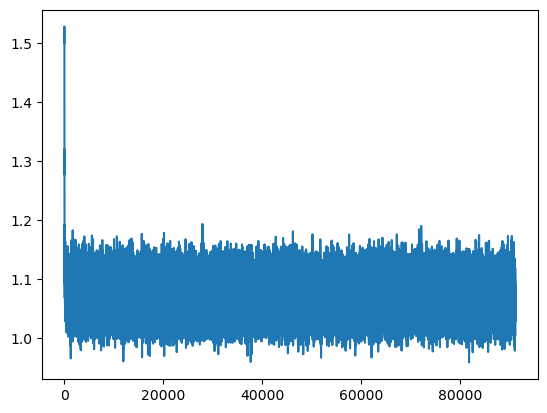

In [43]:

#def movingaverage(interval, window_size):
#    window= np.ones(int(window_size))/float(window_size)
#    return np.convolve(interval, window, 'valid')

plt.plot(baseline_losses)
#plt.yscale('log')
#plt.xscale('log')

print(np.mean(baseline_losses[-100:]))
print(-np.log(1/4))